<a href="https://colab.research.google.com/github/MWFK/Time_Series_and_Sequence_with_TensorFlow/blob/main/4-Windowed_LSTM(2_real_datasets).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, title, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-09-06 08:30:29--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2020-09-06 08:30:30 (4.71 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [ ]:
# Another dataset to try (daily-min-tmperature), I have added csv extraction file that have the only diffrence in my previous code
# yet no diffrence in conclusion about the models (diffrent trained models)

#!wget --no-check-certificate \
#    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
#    -O /tmp/sunspots.csv

#import csv
#time_step = []
#sunspots = []

#with open('/tmp/sunspots.csv') as csvfile:
#  reader = csv.reader(csvfile, delimiter=',')
#  next(reader)
#  for row in reader:
#    sunspots.append(float(row[2]))
#    time_step.append(int(row[0]))

#series = np.array(sunspots)
#time = np.array(time_step)
#plt.figure(figsize=(10, 6))
#plot_series(time, series)


# Visulization function for the loss

#import matplotlib.image  as mpimg
#import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
#loss=history.history['loss']

#epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
#plt.plot(epochs, loss, 'r')
#plt.title('Training loss')
#plt.xlabel("Epochs")
#plt.ylabel("Loss")
#plt.legend(["Loss"])

#plt.figure()



#zoomed_loss = loss[200:]
#zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
#plt.plot(zoomed_epochs, zoomed_loss, 'r')
#plt.title('Training loss')
#plt.xlabel("Epochs")
#plt.ylabel("Loss")
#plt.legend(["Loss"])

#plt.figure()

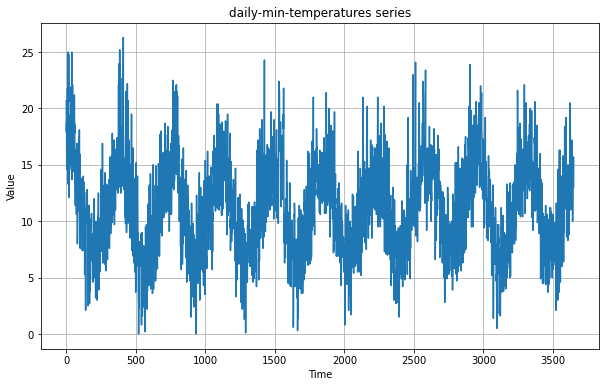

In [ ]:
import csv
time_step = [] # Since we have all the date, we're going to replace it with incremental steps 
temps = [] # For temperature storing

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader) # Get rid of the header
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)   # (3650,)
time = np.array(time_step) # (3650,)
plt.figure(figsize=(10, 6))
title  = str("daily-min-temperatures series")
plot_series(time, series, title)

In [ ]:
series.shape
time.shape

(3650,)

In [ ]:
split_time = 2500 # We have 10 years worth of data (3650) so the split time is more 75% 
time_train = time[:split_time] # 0..2500    => 2500
x_train = series[:split_time] 
time_valid = time[split_time:] # 2501..3650 => 1150
x_valid = series[split_time:]

window_size = 30 # 30 slices worth of data, so we're splitting the x_train 30 times !!!
batch_size = 32
shuffle_buffer_size = 1000


In [ ]:
# Window dataset, we're going to use it on x_train
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1) # This is required since we have specified a specific input function in the model
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
# We take the DNN model, and we try to apply it to our series use the window technique
# So after training it will help us forecast
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    # No map or shuffle, this was done in the windowed_dataset()
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size) # We take a window of x_train
print("train_set= ",train_set)
print("\n x_train.shape= ",x_train.shape)

model = tf.keras.models.Sequential([
  #tf.keras.layers.Conv1D(filters=32, kernel_size=5,
  #                    strides=1, padding="causal",
  #                    activation="relu",
  #                    input_shape=[None, 1]), # We have specified the input shape here so we need to change the windowed_dataset()
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# The whole purpose of this cell is to know which learning rate to use using the lr_schedule
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


train_set=  <PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

 x_train.shape=  (2500,)
Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 0s 22ms/step - loss: 63.3689 - mae: 63.8689
Epoch 2/100
10/10 [==============================] - 0s 33ms/step - loss: 60.4178 - mae: 60.9178
Epoch 3/100
10/10 [==============================] - 0s 31ms/step - loss: 56.1197 - mae: 56.6197
Epoch 4/100
10/10 [==============================] - 0s 32ms/step - loss: 51.1809 - m

(1e-08, 0.0001, 0.0, 60.0)

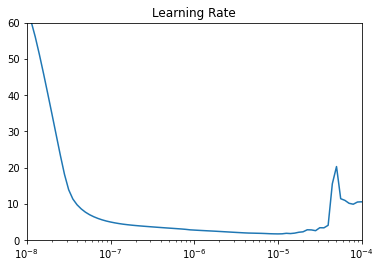

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.title("Learning Rate")
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  #tf.keras.layers.Conv1D(filters=60, kernel_size=5,
  #                    strides=1, padding="causal",
  #                    activation="relu",
  #                    input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# We have inferred from the previouss cell that the preferred Learning rate is 1e-5
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 0s 15ms/step - loss: 14.2951 - mae: 14.7807
Epoch 2/150
25/25 [==============================] - 0s 18ms/step - loss: 2.6071 - mae: 3.0660
Epoch 3/150
25/25 [==============================] - 0s 14ms/step - loss: 1.9526 - mae: 2.4049
Epoch 4/150
25/25 [==============================] - 0s 14ms/step - loss: 1.8317 - mae: 2.2828
Epoch 5/150
25/25 [==============================] - 0s 15ms/step - loss: 1.7460 - mae: 2.1952
Epoch 6/150
25/25 [============

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size) # Forecasting model using the entire series, but the model was built using x_train only !!!
print("1",rnn_forecast) # ndarray
                        #[[[13.685658 ]
                        #  [15.016389 ]
                        #  ...
                        #  [16.840849 ]]] => return the slices, each slice has a set of diffrent prediction

rnn_forecast = rnn_forecast[split_time - window_size:-1,-1,0]    # Predicting the next value aftyer the end of the data set
                                                                 # [11.329407 10.70548  12.124748 ... 13.604228 13.796526 15.009093]
                                                                 # We do this formatting because w have three dimensional data
                                                                 # Data extraction to be compared with the validation set
                                                                 # shape (1150,)
                                                                 # Here we have retrievd the data corresponding to the validation data !!!
                                                                 # -1 to remove the last element

#rnn_forecast = rnn_forecast[split_time - window_size:-1, -1]    # [[11.329407]
                                                                 # [10.70548 ]
                                                                 #  ...
                                                                 # [15.009093]] => return the slices, each slice has a set of diffrent prediction
                                                                 # shape (1150, 1) 

#rnn_forecast = rnn_forecast[split_time - window_size:-1]      # [[[ 8.725445 ]
                                                               # [ 8.182059 ]
                                                               # [ 7.992354 ]
                                                               # ...
                                                               # [10.032068 ]]]
                                                               # rnn_forecast = rnn_forecast[split_time - window_size:-1,]     # The same as the previous
                                                               # shape (1150, 64, 1)

# rnn_forecast[split_time - window_size]                       # [[ 8.725445 ]
                                                               # [ 8.182059 ]
                                                               # ...
                                                               # 64 vaues were printed

# rnn_forecast[split_time - window_size:]                      # shape (1151, 64, 1), so split_time - window_size:-1 in the first expression is to exclude the last element => (1150,)

print("\n2",rnn_forecast.shape)   

1 [[[14.683345]
  [16.242672]
  [17.151323]
  ...
  [16.28469 ]
  [15.875965]
  [14.482027]]

 [[13.832918]
  [15.992167]
  [15.528419]
  ...
  [15.873161]
  [14.479595]
  [15.016482]]

 [[14.120683]
  [14.75979 ]
  [15.345606]
  ...
  [14.476993]
  [15.013997]
  [13.188106]]

 ...

 [[12.269394]
  [15.070842]
  [14.5172  ]
  ...
  [13.651975]
  [13.43649 ]
  [13.382838]]

 [[13.994464]
  [14.294977]
  [14.74834 ]
  ...
  [13.436222]
  [13.38258 ]
  [14.542994]]

 [[11.866609]
  [13.658399]
  [14.182423]
  ...
  [13.381837]
  [14.542234]
  [13.086681]]]

2 (1150,)


(1150,)
(1150,)
(1150,)


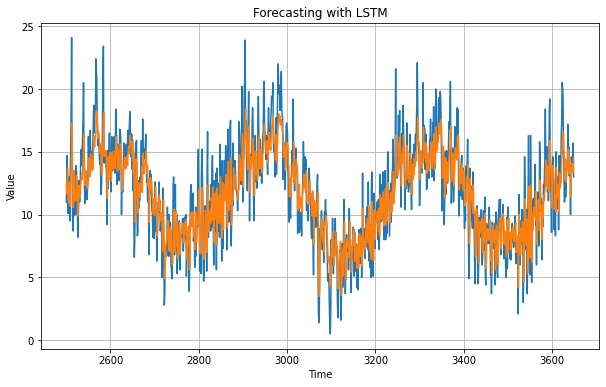

In [ ]:
print(time_valid.shape)       # (1150,)
print(x_valid.shape)          # (1150,)
print(rnn_forecast.shape)     # (1150,)

plt.figure(figsize=(10, 6))
title = str("Forecasting with LSTM")
plot_series(time_valid, x_valid, title) # 2-D
plot_series(time_valid, rnn_forecast, title) # we only took the last part of the rnn_forecast

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy() # CNN LSTM 1.77

1.8085914

<Figure size 432x288 with 0 Axes>

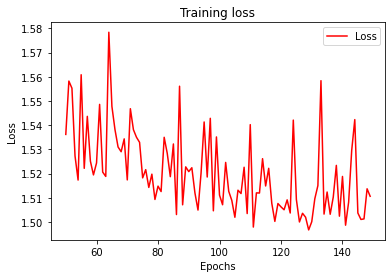

<Figure size 432x288 with 0 Axes>

In [ ]:
# I have added this part to check the loss

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[50:]
zoomed_epochs = range(50,150)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
print(rnn_forecast)

[12.400693  11.639971  12.620131  ... 13.4367485 13.382838  14.542994 ]
